# Nội dung thực hành

1. Cài MongoDB  
2. Dùng Python làm việc với MongoDB (tạo dữ liệu, truy vấn)  
3. Thực hành 1 và 2 cho dự án cuối môn  

# Cài MongoDB  

Dưới đây là hướng dẫn cài đặt trên ArchLinux 

Yêu cầu: Cài sẵn package manager như yay, ...

In [4]:
# !yay -S install mongodb-bin

# check mongodb version
!mongod --version

db version v7.0.6
Build Info: {
    "version": "7.0.6",
    "gitVersion": "66cdc1f28172cb33ff68263050d73d4ade73b9a4",
    "openSSLVersion": "OpenSSL 1.1.1w  11 Sep 2023",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2004",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


Dưới đây là tùy chọn khởi động mongodb 

In [ ]:
# !sudo systemctl start mongodb
# !sudo systemctl status mongodb
# !systemctl enable mongodb

# Dùng Python làm việc với MongoDB

## Cài đăt gói pymongo - API để code Python hoạt động với MongoDB  

In [5]:
!pip install pymongo

## Chương trình Python kết nối với cơ sở dữ liệu MongoDB

In [6]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client["image_db"]

In [7]:
print(client.list_database_names())

['admin', 'config', 'homework_lap9', 'local', 'test']


Không thấy image_db vì Database chỉ được khởi tạo khi nó không rỗng

## Khởi tạo collection 'images' 

In [8]:
col = db["images"]

In [9]:
print(db.list_collection_names())

[]


Tương tự không thấy images vì 1 collection chỉ được khởi tạo khi có content 

## Thêm Document vào Collection: giống việc thêm 1 Record vào 1 Table

Có thể dùng insert_one() hoặc insert_many() tùy nhu cầu

In [17]:
import cv2
import gridfs  # use to store image

data_path = "/mnt/DataK/Project/ClassifyThyroidCancer/data/B6/0.jpg"
image1 = cv2.imread(data_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# convert ndarray to string
imageString = image1.tostring()

fs = gridfs.GridFS(db)
# store the image
image1_ID = fs.put(imageString, encoding="utf-8")

# create our image meta data
meta = {
    "label": "B6",
    "image": {"imageID": image1_ID, "shape": image1.shape, "dtype": str(image1.dtype)},
}

# insert the meta data
x = col.insert_one(meta)    # also can use col.insert_many()

/tmp/ipykernel_12419/3385559093.py:9: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  imageString = image1.tostring()


## Truy vấn Document (Find Querry) và hiện ra ảnh kết quả lưu trữ

Có thể dùng find() hoặc find_one() tùy nhu cầu

In [47]:
doc = col.find({'label': 'B6'})  
print(doc[0])
print(doc[0].get('image')[0].get('imageID'))

{'_id': ObjectId('65f1164576ec7822a99d1255'), 'label': 'B6', 'image': [{'imageID': ObjectId('65f1164576ec7822a99d124a'), 'shape': [768, 1024, 3], 'dtype': 'uint8'}]}
65f1164576ec7822a99d124a


In [48]:
import numpy as np 

# get the image meta data
query = {'label': 'B6'}
doc = col.find(query)  

# get the image from gridfs
gOut = fs.get(doc[0].get('image')[0].get('imageID'))

# convert bytes to ndarray
img = np.frombuffer(gOut.read(), dtype=np.uint8)

# reshape to match the image size
img = np.reshape(img, doc[0].get('image')[0].get('shape'))

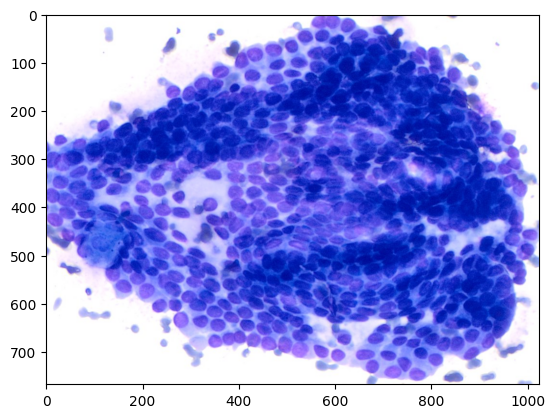

In [49]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

Phía trên là ví dụ truy vấn đơn giản. Ngoài ra có thể cải thiện biểu thức truy vấn query bằng:  
  
  1. Advanced Query:  
  E.g. to find the documents where the "address" field starts with the letter "S" or higher (alphabetically), use the greater than modifier: query = {"$gt": "S"}  
  
  2. Filter With Regular Expressions:  
  To find only the documents where the "address" field starts with the letter "S", use the regular expression: query = {"$regex": "^S"}  

## Sắp xếp kết quả truy vấn theo thứ tự mong muốn

In [51]:
doc = col.find().sort("_id")
# Tùy chọn:
# sort("_id", 1) #ascending
# sort("_id", -1) #descending

for x in doc:
  print(x)

{'_id': ObjectId('65f1164576ec7822a99d1255'), 'label': 'B6', 'image': [{'imageID': ObjectId('65f1164576ec7822a99d124a'), 'shape': [768, 1024, 3], 'dtype': 'uint8'}]}
{'_id': ObjectId('65f1167976ec7822a99d1261'), 'label': 'B6', 'image': {'imageID': ObjectId('65f1167976ec7822a99d1256'), 'shape': [768, 1024, 3], 'dtype': 'uint8'}}
{'_id': ObjectId('65f116fc76ec7822a99d126d'), 'id': '0', 'label': 'B6', 'image': {'imageID': ObjectId('65f116fc76ec7822a99d1262'), 'shape': [768, 1024, 3], 'dtype': 'uint8'}}
{'_id': ObjectId('65f1178b76ec7822a99d1279'), 'id': '0', 'label': 'B6', 'image': {'imageID': ObjectId('65f1178b76ec7822a99d126e'), 'shape': [768, 1024, 3], 'dtype': 'uint8'}}


## Xóa Document trong 1 Collection: Giống việc xóa 1 Record trong 1 Table

Sử dụng delete_one(query) hoặc delete_many(query) tùy theo nhu cầu

In [52]:
query = {'label': 'B6'}

x = col.delete_many(query)

# hoặc dùng lệnh sau để xóa mọi document trong collection
# x = col.delete_many({})

print(x.deleted_count, " documents deleted.") 

4  documents deleted.


## Xóa Collection trong 1 DataBase: Giống việc xóa 1 Table trong 1 DataBase

Sử dụng db.collection.drop()

In [53]:
# Liệt kê các collection có
print(db.list_collection_names())

['fs.chunks', 'images', 'fs.files']


In [ ]:
# col = db["images"]
# col.drop()

Sau khi chạy 2 lệnh trên thì Collection 'images' sẽ bị xóa

## Sửa đổi Document trong 1 Collection: Giống việc thay đổi 1 Record trong 1 Table

Sử dụng phương thức update_one() hoặc update_many().  
  
'''{python}  
myquery = { "address": "Valley 345" } - đây là para1   
newvalues = { "$set": { "address": "Canyon 123" } } - đây là para2  
col.update_one(myquery, newvalues)  
col.update_many(myquery, newvalues)  
'''  

## Xóa Document trong 1 Collection: Giống việc xóa 1 Record trong 1 Table 

Sử dụng phương thức delete_one(query) hoặc delete_many(query).

## Limit Result Return: Giới hạn số lượng Document truy vấn về

Sử dụng phương thức limit(number)  
  
Eg: Giới hạn lại chỉ ở 5 kết quả  
myresult = mycol.find().limit(5)  

## Xóa 1 Database

Sử dụng db.collection.drop()

In [54]:
print(client.list_database_names())

['admin', 'config', 'homework_lap9', 'image_db', 'local', 'test']


In [57]:
client.drop_database('homework_lap9')

In [58]:
print(client.list_database_names())

['admin', 'config', 'image_db', 'local', 'test']


In [59]:
client.drop_database('image_db')
print(client.list_database_names())

['admin', 'config', 'local', 'test']


# Thực hành cho dự án cuối môn

Ví dụ thực hành ở trên là phục vụ cho lưu trữ dữ liệu ảnh + nhãn phân loại của ảnh đó.  
Qua đó giúp lưu trữ & truy vấn data cho dự án cuối kỳ của nhóm em: Phân loại ung thư dạ dày.  